In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic

import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
az.style.use('arviz-darkgrid')

## Modeling functions 

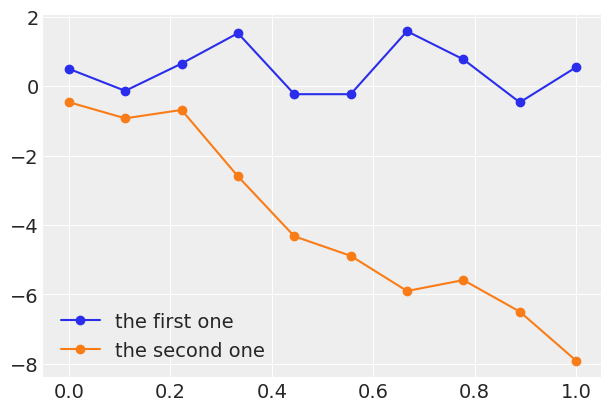

In [3]:
np.random.seed(42)
x = np.linspace(0, 1, 10)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')

plt.legend();

### Covariance functions and kernels

In [4]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

In [5]:
#  def linear_kernel(x, knots):
#      """ linear kernel """
#     return np.array([(x - 2) * (k - 2) for k in knots])

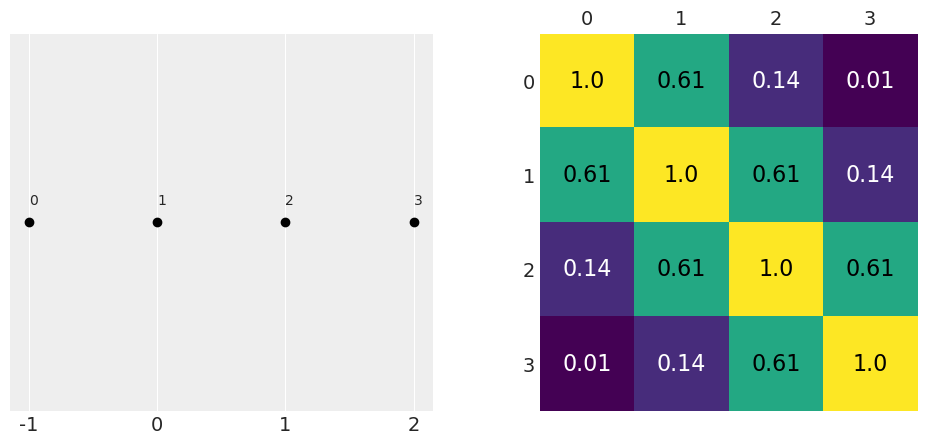

In [6]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

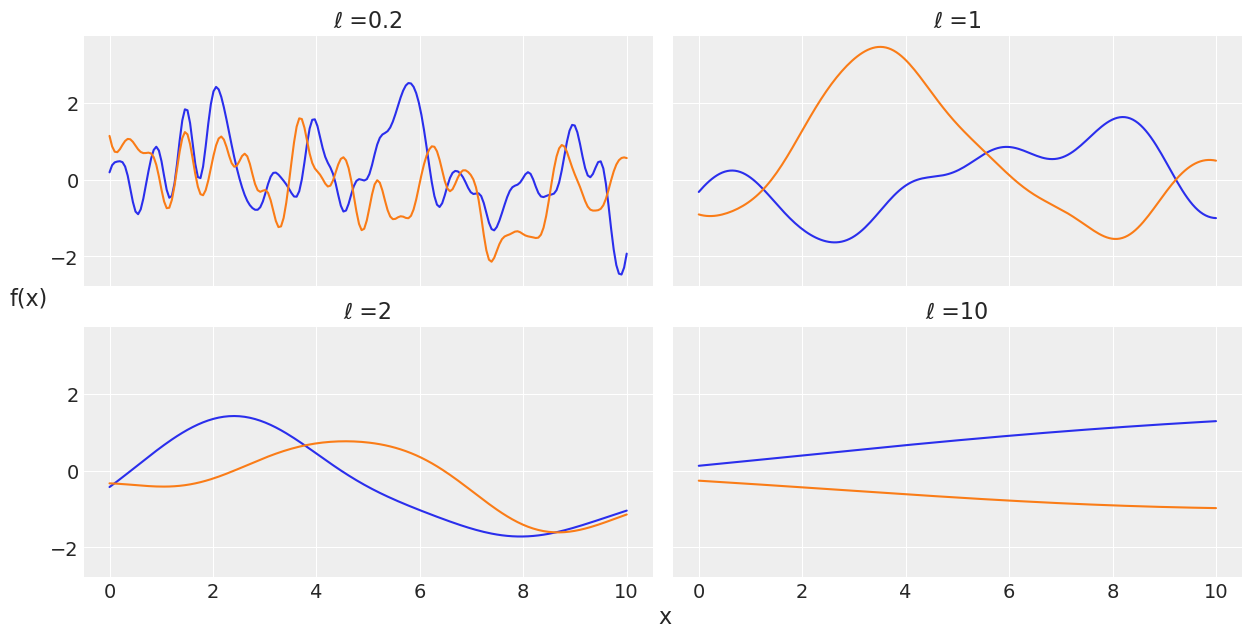

In [7]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)
 
for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16);

## Gaussian Process regression

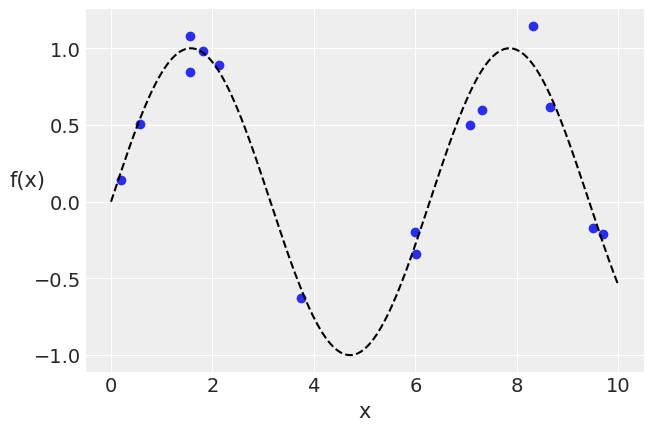

In [8]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0);

In [9]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    trace_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, ℓ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:43<00:00, 115.20draws/s]


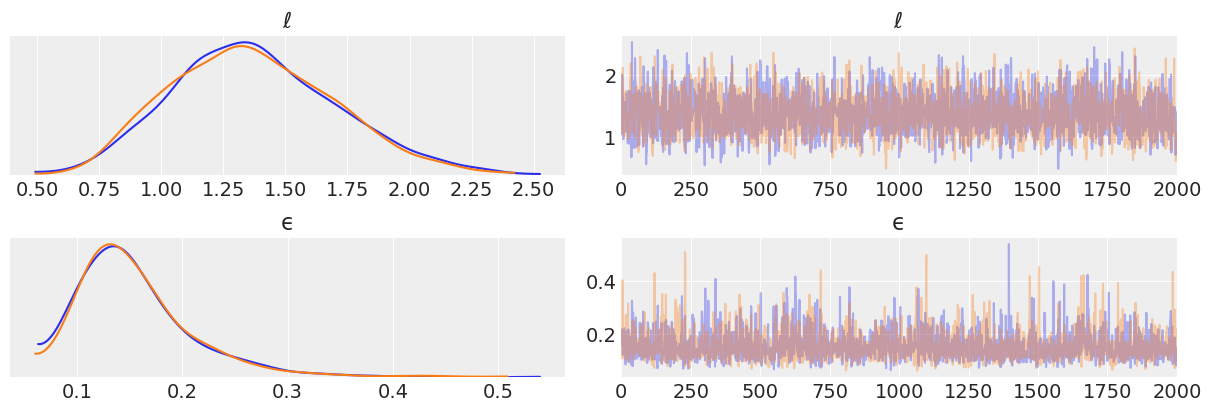

In [10]:
az.plot_trace(trace_reg);

In [11]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

In [12]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred], samples=82)

100%|██████████| 82/82 [00:01<00:00, 41.22it/s]


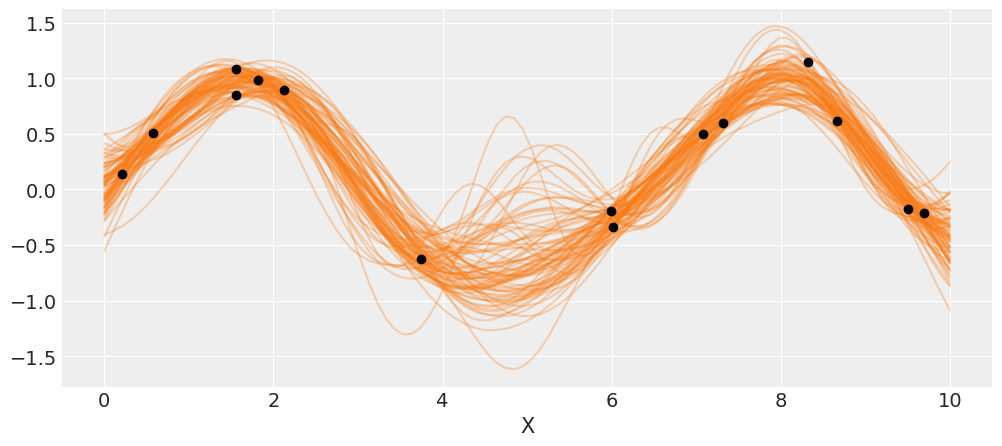

In [13]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X');

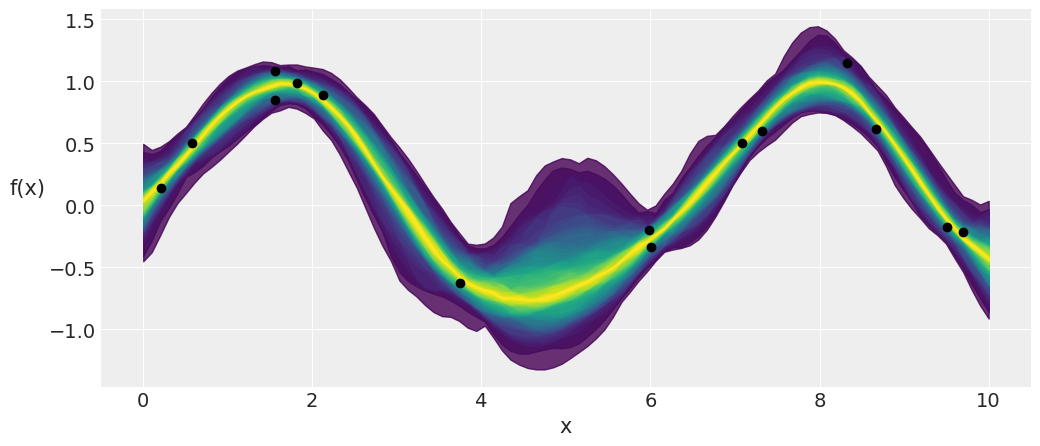

In [14]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette='viridis', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15);

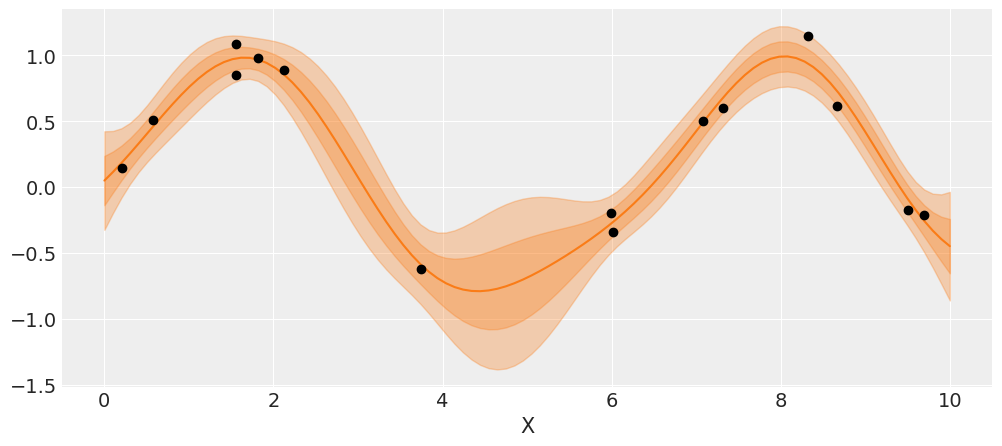

In [15]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': trace_reg['ℓ'].mean(), 'ϵ': trace_reg['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X');

## Regression with spatial autocorrelation

In [16]:
islands_dist = pd.read_csv('../data/islands_dist.csv', sep=',', index_col=0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [17]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


In [18]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [19]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    trace_islands = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α, f_rotated_, ℓ, η]
Sampling 2 chains: 100%|██████████| 4000/4000 [06:47<00:00,  9.81draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8925347845297029, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
#az.summary(trace_islands, var_names=['α', 'β', 'η', 'ℓ', 'f'])

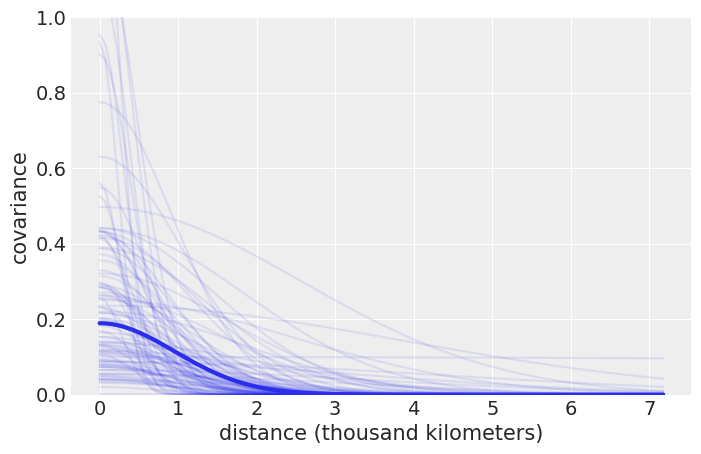

In [21]:
trace_η = trace_islands['η']
trace_ℓ = trace_islands['ℓ']

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)

ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] * xrange**2)).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance');

In [22]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns, columns=islands_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.88,0.80,0.00,0.43,0.10,0.00,0.01,0.15,0.0
Ti,0.88,1.00,0.95,0.00,0.43,0.11,0.01,0.02,0.12,0.0
SC,0.80,0.95,1.00,0.00,0.27,0.20,0.02,0.05,0.06,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.04,0.26,0.24,0.00,0.0
Fi,0.43,0.43,0.27,0.00,1.00,0.00,0.00,0.00,0.73,0.0
Tr,0.10,0.11,0.20,0.04,0.00,1.00,0.17,0.67,0.00,0.0
Ch,0.00,0.01,0.02,0.26,0.00,0.17,1.00,0.44,0.00,0.0
Mn,0.01,0.02,0.05,0.24,0.00,0.67,0.44,1.00,0.00,0.0
To,0.15,0.12,0.06,0.00,0.73,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


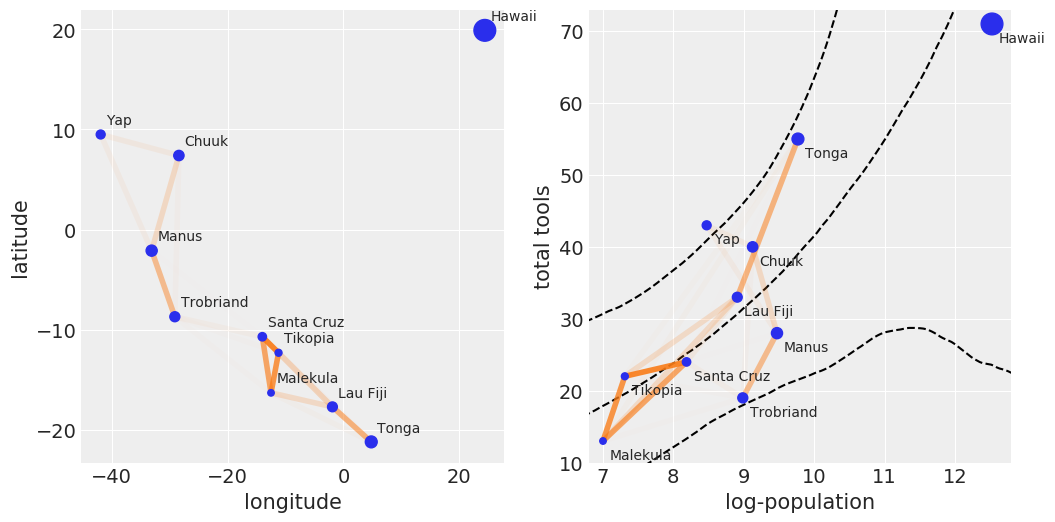

In [23]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['α'][:, None] +
                     trace_islands['β'][:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hpd(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73);

### Gaussian process classification

In [24]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [25]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [26]:
with pm.Model() as model_iris:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris = pm.sample(1000, chains=1, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]
100%|██████████| 1500/1500 [01:26<00:00, 17.33it/s]


In [27]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]

with model_iris:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(
        trace_iris, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [00:53<00:00, 18.65it/s]


In [28]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

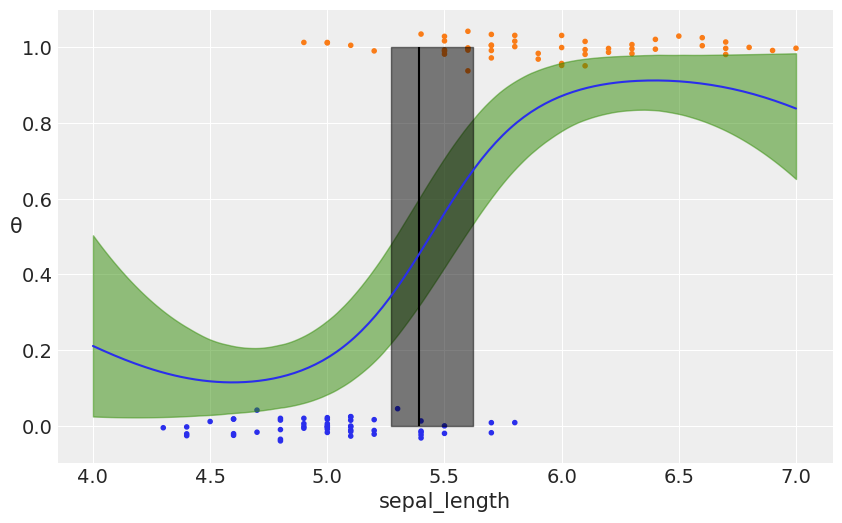

In [29]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hpd(X_new[:, 0], fp, color='C2')

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0);

In [30]:
with pm.Model() as model_iris2:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    trace_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, τ, c, ℓ]
100%|██████████| 1500/1500 [01:31<00:00, 16.39it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris2,
                                                  vars=[f_pred],
                                                  samples=1000)

100%|██████████| 1000/1000 [00:58<00:00, 17.24it/s]


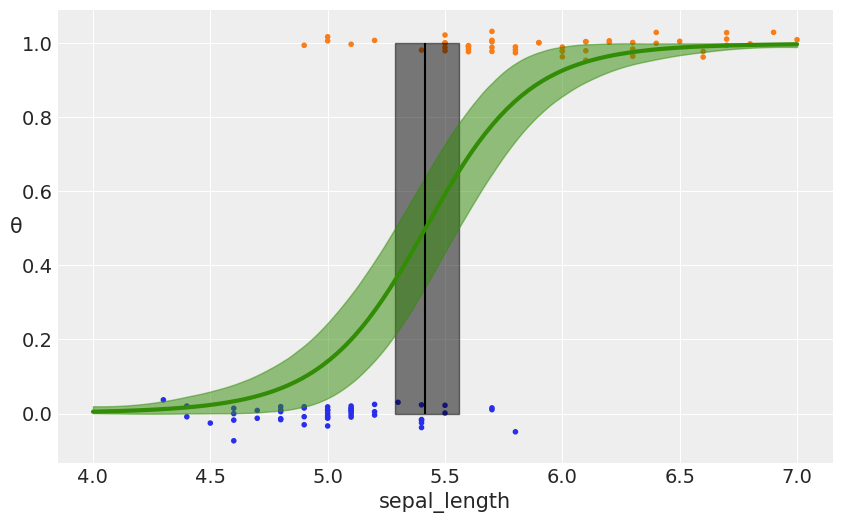

In [32]:

_, ax = plt.subplots(figsize=(10,6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), marker='.', color=[f'C{ci}' for ci in y])

db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hpd(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)

ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hpd(X_new[:,0], fp, color='C2')

ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0);

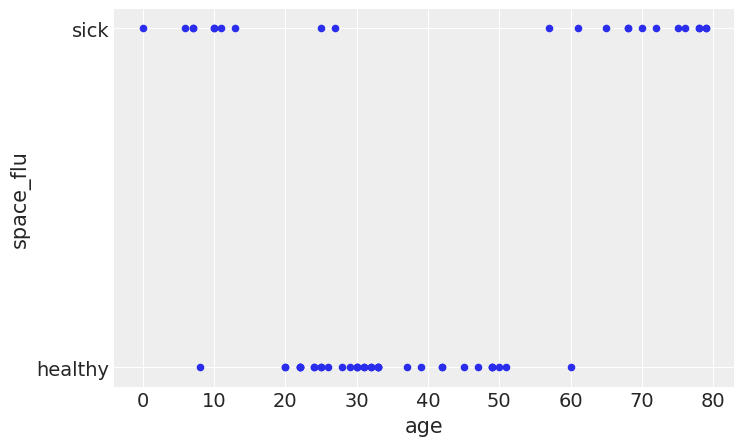

In [33]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick']);

In [34]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    trace_space_flu = pm.sample(
        1000, chains=1, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]
100%|██████████| 1500/1500 [00:44<00:00, 34.05it/s]


In [35]:
X_new = np.linspace(0, 80, 200)[:, None]

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_space_flu,
                                                  vars=[f_pred],
                                                  samples=1000)

100%|██████████| 1000/1000 [00:51<00:00, 19.31it/s]


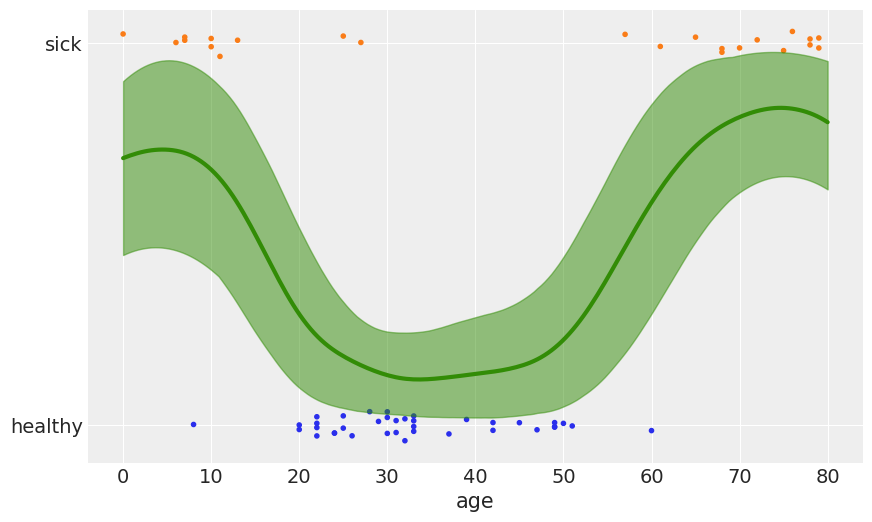

In [36]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hpd(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age');

### the coal-mining disaster

In [37]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


In [38]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [39]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    trace_coal = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ℓ]
100%|██████████| 1500/1500 [00:34<00:00, 43.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


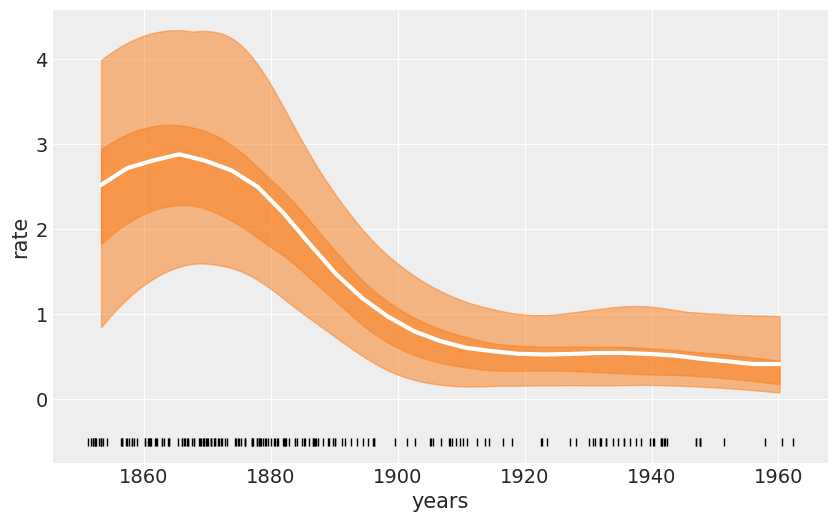

In [40]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(trace_coal['f'])
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hpd(x_centers, f_trace)

az.plot_hpd(x_centers, f_trace, credible_interval=0.5,
            plot_kwargs={'alpha': 0})

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate');

### the redwood data

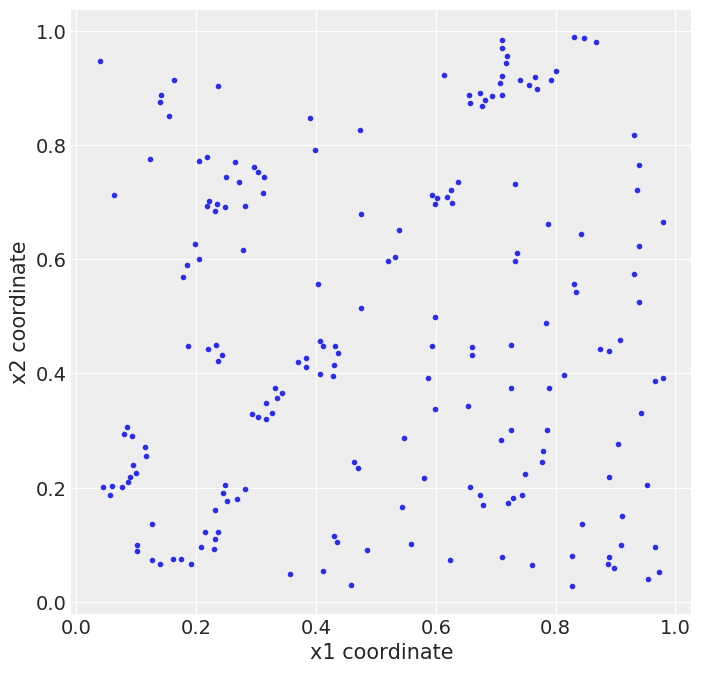

In [41]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate');

In [42]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [43]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    trace_rw = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, ℓ]
Sampling 2 chains: 100%|██████████| 3000/3000 [04:34<00:00, 10.92draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [44]:
az.summary(trace_rw, var_names=['ℓ'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
ℓ[0],0.13,0.03,0.0,0.08,0.19,299.0,1.0
ℓ[1],0.09,0.02,0.0,0.05,0.14,242.0,1.0


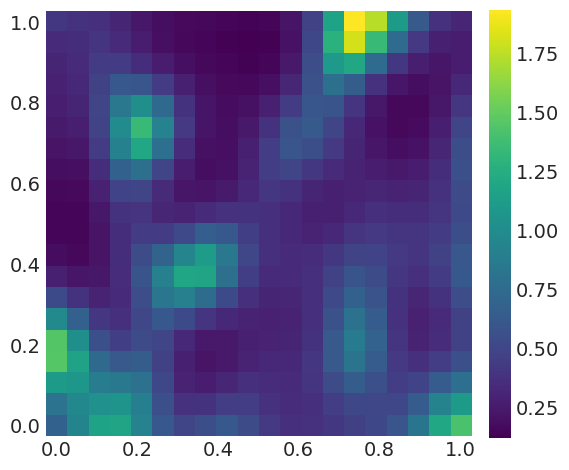

In [45]:
rate = np.exp(np.mean(trace_rw['f'], axis=0).reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04);